# Deep Crossentropy method

In this section we'll extend your CEM implementation with neural networks! You will train a multi-layer neural network to solve simple continuous state space games. __Please make sure you're done with tabular crossentropy method from the previous notebook.__

![img](https://watanimg.elwatannews.com/old_news_images/large/249765_Large_20140709045740_11.jpg)



In [1]:
import sys, os
if 'google.colab' in sys.modules and not os.path.exists('.setup_complete'):
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/setup_colab.sh -O- | bash
    !touch .setup_complete

# This code creates a virtual display to draw game images on.
# It will have no effect if your machine has a monitor.
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

Selecting previously unselected package libfontenc1:amd64.
(Reading database ... 121753 files and directories currently installed.)
Preparing to unpack .../0-libfontenc1_1%3a1.1.4-1build3_amd64.deb ...
Unpacking libfontenc1:amd64 (1:1.1.4-1build3) ...
Selecting previously unselected package libxfont2:amd64.
Preparing to unpack .../1-libxfont2_1%3a2.0.5-1build1_amd64.deb ...
Unpacking libxfont2:amd64 (1:2.0.5-1build1) ...
Selecting previously unselected package libxkbfile1:amd64.
Preparing to unpack .../2-libxkbfile1_1%3a1.1.0-1build3_amd64.deb ...
Unpacking libxkbfile1:amd64 (1:1.1.0-1build3) ...
Selecting previously unselected package x11-xkb-utils.
Preparing to unpack .../3-x11-xkb-utils_7.7+5build4_amd64.deb ...
Unpacking x11-xkb-utils (7.7+5build4) ...
Selecting previously unselected package xfonts-encodings.
Preparing to unpack .../4-xfonts-encodings_1%3a1.0.5-0ubuntu2_all.deb ...
Unpacking xfonts-encodings (1:1.0.5-0ubuntu2) ...
Selecting previously unselected package xfonts-util

In [2]:
from IPython.display import clear_output

def show_progress(rewards_batch, log, percentile, reward_range=[-990, +10]):
    """
    A convenience function that displays training progress.
    No cool math here, just charts.
    """

    mean_reward = np.mean(rewards_batch)
    threshold = np.percentile(rewards_batch, percentile)
    log.append([mean_reward, threshold])

    clear_output(True)
    print("mean reward = %.3f, threshold=%.3f" % (mean_reward, threshold))
    plt.figure(figsize=[8, 4])
    plt.subplot(1, 2, 1)
    plt.plot(list(zip(*log))[0], label='Mean rewards')
    plt.plot(list(zip(*log))[1], label='Reward thresholds')
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.hist(rewards_batch, range=reward_range)
    plt.vlines([np.percentile(rewards_batch, percentile)],
               [0], [100], label="percentile", color='red')
    plt.legend()
    plt.grid()

    plt.show()

In [3]:
def generate_session(env, agent, t_max=1000):
    """
    Play a single game using agent neural network.
    Terminate when game finishes or after :t_max: steps
    """
    states, actions = [], []
    total_reward = 0

    s = env.reset()

    for t in range(t_max):

        # use agent to predict a vector of action probabilities for state :s:
        probs = agent.predict_proba([s]).reshape(-1)

        assert probs.shape == (env.action_space.n,), "make sure probabilities are a vector (hint: np.reshape)"

        # use the probabilities you predicted to pick an action
        # sample proportionally to the probabilities, don't just take the most likely action
        a = np.random.choice(env.action_space.n, p=probs)

        new_s, r, done, info = env.step(a)

        # record sessions like you did before
        states.append(s)
        actions.append(a)
        total_reward += r

        s = new_s
        if done:
            break
    return states, actions, total_reward

In [4]:
def select_elites(states_batch, actions_batch, rewards_batch, percentile=50):
    """
    Select states and actions from games that have rewards >= percentile
    :param states_batch: list of lists of states, states_batch[session_i][t]
    :param actions_batch: list of lists of actions, actions_batch[session_i][t]
    :param rewards_batch: list of rewards, rewards_batch[session_i]

    :returns: elite_states,elite_actions, both 1D lists of states and respective actions from elite sessions

    Please return elite states and actions in their original order
    [i.e. sorted by session number and timestep within session]

    If you are confused, see examples below. Please don't assume that states are integers
    (they will become different later).
    """

    reward_threshold = np.percentile(rewards_batch, percentile)
    elite_states = []
    elite_actions = []

    for i in range(len(rewards_batch)):
        if rewards_batch[i] >= reward_threshold:
            elite_states.extend(states_batch[i])
            elite_actions.extend(actions_batch[i])

    return elite_states, elite_actions

# Homework part II

### Deep crossentropy method

By this moment, you should have got enough score on [CartPole-v0](https://gym.openai.com/envs/CartPole-v0) to consider it solved (see the link). It's time to try something harder.

* if you have any trouble with CartPole-v0 and feel stuck, feel free to ask us or your peers for help.

### Tasks

* __2.1__ (3 pts) Pick one of environments: `MountainCar-v0` or `LunarLander-v2`.
  * For MountainCar, get average reward of __at least -150__
  * For LunarLander, get average reward of __at least +50__

See the tips section below, it's kinda important.
__Note:__ If your agent is below the target score, you'll still get some of the points depending on the result, so don't be afraid to submit it.
  
  
* __2.2__ (up to 6 pts) Devise a way to speed up training against the default version
  * Obvious improvement: use [`joblib`](https://joblib.readthedocs.io/en/latest/). However, note that you will probably need to spawn a new environment in each of the workers instead of passing it via pickling. (2 pts)
  * Try re-using samples from 3-5 last iterations when computing threshold and training. (2 pts)
  * Obtain __-100__ at `MountainCar-v0` or __+200__ at `LunarLander-v2` (2 pts). Feel free to experiment with hyperparameters, architectures, schedules etc.
  
__Please list what you did in Anytask submission form__. This reduces probability that somebody misses something.
  
  
### Tips
* Gym page: [MountainCar](https://gym.openai.com/envs/MountainCar-v0), [LunarLander](https://gym.openai.com/envs/LunarLander-v2)
* Sessions for MountainCar may last for 10k+ ticks. Make sure ```t_max``` param is at least 10k.
 * Also it may be a good idea to cut rewards via ">" and not ">=". If 90% of your sessions get reward of -10k and 10% are better, than if you use percentile 20% as threshold, R >= threshold __fails to cut off bad sessions__ while R > threshold works alright.
* _issue with gym_: Some versions of gym limit game time by 200 ticks. This will prevent cem training in most cases. Make sure your agent is able to play for the specified __t_max__, and if it isn't, try `env = gym.make("MountainCar-v0").env` or otherwise get rid of TimeLimit wrapper.
* If you use old _swig_ lib for LunarLander-v2, you may get an error. See this [issue](https://github.com/openai/gym/issues/100) for solution.
* If it doesn't train, it's a good idea to plot reward distribution and record sessions: they may give you some clue. If they don't, call course staff :)
* 20-neuron network is probably not enough, feel free to experiment.

You may find the following snippet useful:

#**№2.1 (MountainCar)**

In [ ]:
import numpy as np
import gym
np.random.seed(2023)
env = gym.make("MountainCar-v0").env
env.reset()

n_actions = env.action_space.n
state_dim = env.observation_space.shape[0]
n_actions, state_dim

(3, 2)

In [ ]:
np.random.seed(2023)
agent_car = MLPClassifier(
    hidden_layer_sizes=(80, 40),
    activation='tanh',
)
agent_car.partial_fit([env.reset()] * n_actions, range(n_actions), range(n_actions))

MLPClassifier(activation='tanh', hidden_layer_sizes=(80, 40))

In [ ]:
s = env.reset()
probs = agent_car.predict_proba([s]).reshape(-1)
probs

array([0.39049926, 0.29219617, 0.31730457])

In [ ]:
import time

mean reward = -147.730, threshold=-147.000


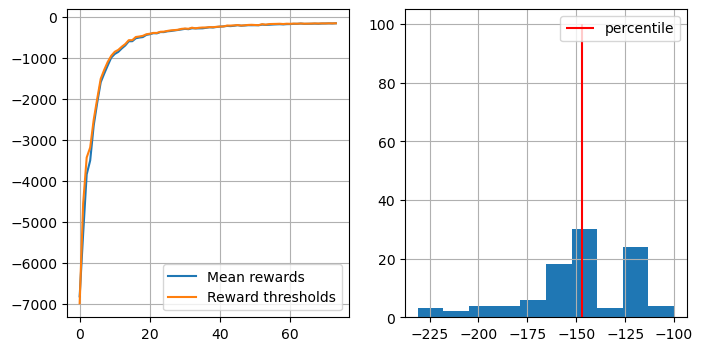

Done!
CPU times: total: 15min 26s
Wall time: 14min 23s


In [ ]:
%%time
np.random.seed(2023)
n_sessions = 100
percentile = 50
log = []

for _ in range(200):
    sessions = [generate_session(env, agent_car, t_max=10**4) for _ in range(n_sessions)]

    states_batch, actions_batch, rewards_batch = map(np.array, zip(*sessions))
    elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, percentile)

    agent_car.partial_fit(elite_states, elite_actions)

    show_progress(rewards_batch, log, percentile, reward_range=[np.min(rewards_batch), -100])

    if np.mean(rewards_batch) > -150:
        print("Done!")
        break

In [ ]:
import gym.wrappers

with gym.wrappers.Monitor(gym.make("MountainCar-v0").env, directory="videos", force=True) as env_monitor:
    sessions = [generate_session(env_monitor, agent_car) for _ in range(100)]

In [ ]:
def visualize_mountain_car(env, agent):
    # Compute policy for all possible x and v (with discretization)
    xs = np.linspace(env.min_position, env.max_position, 100)
    vs = np.linspace(-env.max_speed, env.max_speed, 100)

    grid = np.dstack(np.meshgrid(xs, vs[::-1])).transpose(1, 0, 2)
    grid_flat = grid.reshape(len(xs) * len(vs), 2)
    probs = agent.predict_proba(grid_flat).reshape(len(xs), len(vs), 3).transpose(1, 0, 2)

    # # The above code is equivalent to the following:
    # probs = np.empty((len(vs), len(xs), 3))
    # for i, v in enumerate(vs[::-1]):
    #     for j, x in enumerate(xs):
    #         probs[i, j, :] = agent.predict_proba([[x, v]])[0]

    # Draw policy
    f, ax = plt.subplots(figsize=(7, 7))
    ax.imshow(probs, extent=(env.min_position, env.max_position, -env.max_speed, env.max_speed), aspect='auto')
    ax.set_title('Learned policy: red=left, green=nothing, blue=right')
    ax.set_xlabel('position (x)')
    ax.set_ylabel('velocity (v)')

    # Sample a trajectory and draw it
    states, actions, _ = generate_session(env, agent)
    states = np.array(states)
    ax.plot(states[:, 0], states[:, 1], color='white')

    # Draw every 3rd action from the trajectory
    for (x, v), a in zip(states[::3], actions[::3]):
        if a == 0:
            plt.arrow(x, v, -0.1, 0, color='white', head_length=0.02)
        elif a == 2:
            plt.arrow(x, v, 0.1, 0, color='white', head_length=0.02)


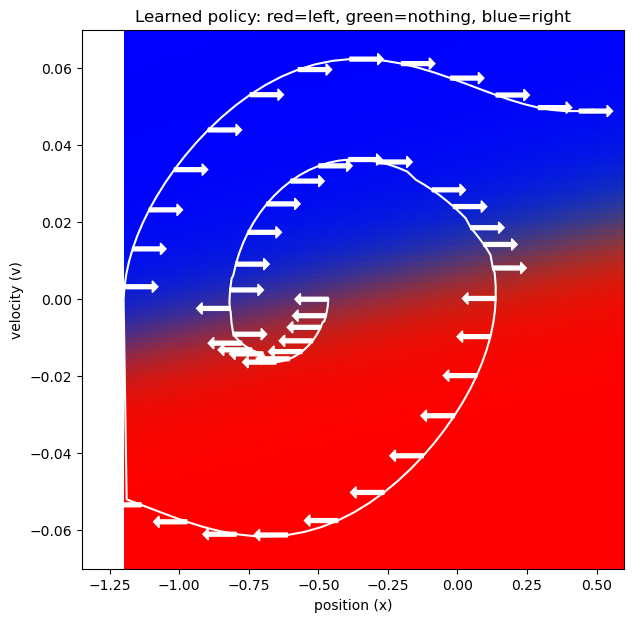

In [ ]:
with gym.make('MountainCar-v0').env as env:
    visualize_mountain_car(env, agent_car)

#**№2.2 Parallel (MountainCar)**

In [ ]:
from joblib import Parallel, delayed, parallel_backend

In [ ]:
%%time
sessions = [generate_session(env, agent_car, t_max=10**4) for _ in range(10)]

CPU times: total: 54.5 s
Wall time: 55 s


In [ ]:
%%time
with parallel_backend('loky', inner_max_num_threads=-1):
    sessions = Parallel(n_jobs=-1)(delayed(generate_session)(gym.make( "MountainCar-v0").env, agent_car, t_max=10**4) for _ in range(10))

CPU times: total: 2.7 s
Wall time: 24.4 s


In [ ]:
import gym
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.neural_network import MLPClassifier
from IPython.display import clear_output
from tqdm import tqdm, trange
from joblib import Parallel, delayed, parallel_backend

In [ ]:
np.random.seed(2023)
env = gym.make("MountainCar-v0").env
env.reset()

n_actions = env.action_space.n
state_dim = env.observation_space.shape[0]
n_actions, state_dim

(3, 2)

In [ ]:
# reset policy and env
np.random.seed(2023)
env.reset()

agent_car = MLPClassifier(
    hidden_layer_sizes=(80, 40, 20),
    activation='tanh',
)
agent_car.partial_fit([env.reset()] * n_actions, range(n_actions), range(n_actions))

MLPClassifier(activation='tanh', hidden_layer_sizes=(80, 40, 20))

mean reward = -102.517, threshold=-103.000


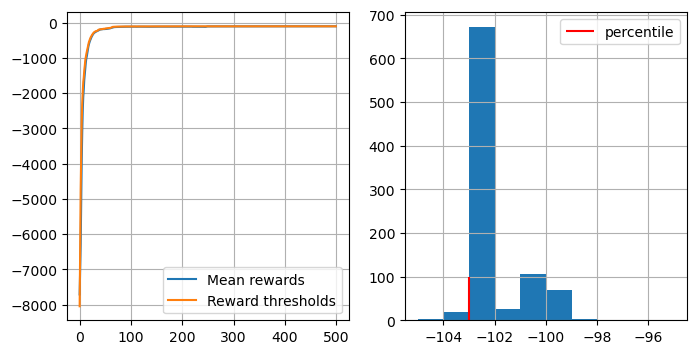

CPU times: total: 39min 34s
Wall time: 38min 6s


In [ ]:
%%time
np.random.seed(2023)
n_sessions = 500
percentile = 60
log = []
q_size = 3
queue = []

for _ in range(500):

    sessions = Parallel(n_jobs=-1, backend="loky")(delayed(generate_session)(gym.make("MountainCar-v0").env, agent_car, t_max=10**4) for _ in range(n_sessions))
    last_rewards_batch = np.array(list(zip(*sessions))[2])

    queue += sessions
    if len(queue) > (n_sessions * q_size):
        queue = queue[-(n_sessions * q_size):]

    states_batch, actions_batch, rewards_batch = map(np.array, zip(*queue))
    elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, percentile)

    agent_car.partial_fit(elite_states, elite_actions)

    show_progress(last_rewards_batch, log, percentile, reward_range=[np.min(rewards_batch), -95])

    if np.mean(last_rewards_batch) > -100:
        print("Done!")
        break

mean reward = -99.584, threshold=-92.000


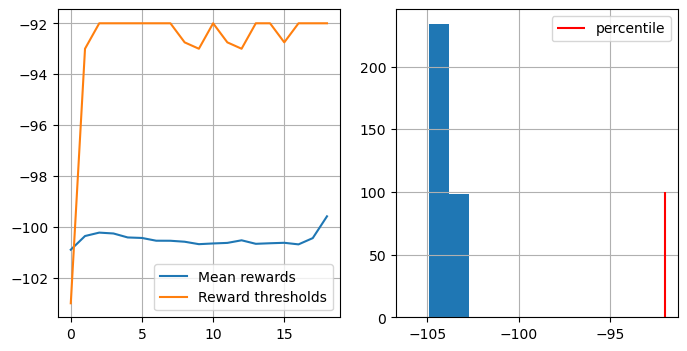

Done!
CPU times: total: 1min 17s
Wall time: 1min 16s


In [ ]:
%%time
np.random.seed(2023)
n_sessions = 500
percentile = 75
log = []
q_size = 3
queue = []

for _ in range(500):

    sessions = Parallel(n_jobs=-1, backend="loky")(delayed(generate_session)(gym.make("MountainCar-v0").env, agent_car, t_max=10**4) for _ in range(n_sessions))
    last_rewards_batch = np.array(list(zip(*sessions))[2])

    queue += sessions
    if len(queue) > (n_sessions * q_size):
        queue = queue[-(n_sessions * q_size):]

    states_batch, actions_batch, rewards_batch = map(np.array, zip(*queue))
    elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, percentile)

    agent_car.partial_fit(elite_states, elite_actions)

    show_progress(last_rewards_batch, log, percentile, reward_range=[np.min(rewards_batch), -95])

    if np.mean(last_rewards_batch) > -100:
        print("Done!")
        break

In [ ]:
with gym.wrappers.Monitor(gym.make("MountainCar-v0").env, directory="video2_mountaincar", force=True) as env_monitor:
    sessions = [generate_session(env_monitor, agent_car) for _ in range(100)]

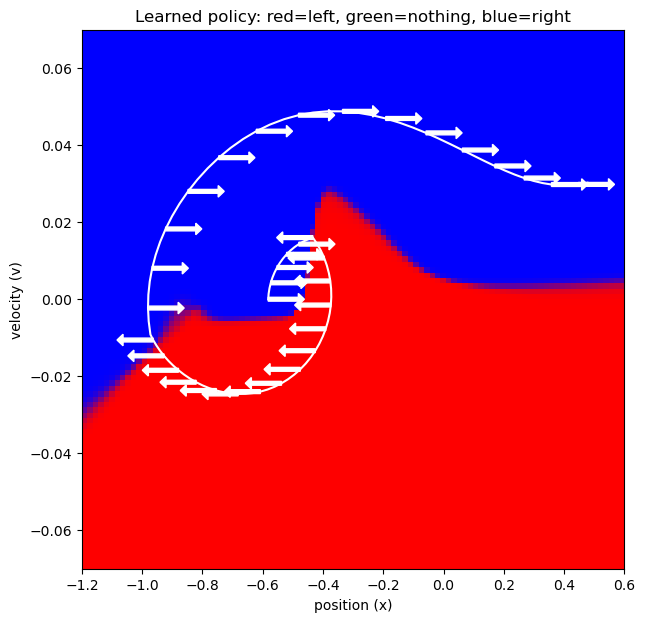

In [ ]:
with gym.make('MountainCar-v0').env as env:
    visualize_mountain_car(env, agent_car)

### Bonus tasks

* __2.3 bonus__ (2 pts) Try to find a network architecture and training params that solve __both__ environments above (_Points depend on implementation. If you attempted this task, please mention it in Anytask submission._)

* __2.4 bonus__ (4 pts) Solve continuous action space task with `MLPRegressor` or similar.
  * Since your agent only predicts the "expected" action, you will have to add noise to ensure exploration.
  * Choose one of [MountainCarContinuous-v0](https://gym.openai.com/envs/MountainCarContinuous-v0) (90+ pts to solve), [LunarLanderContinuous-v2](https://gym.openai.com/envs/LunarLanderContinuous-v2) (200+ pts to solve)
  * 4 points for solving. Slightly less for getting some results below solution threshold. Note that discrete and continuous environments may have slightly different rules, aside from action spaces.

### **№2.3 LunarLander**


In [ ]:
np.random.seed(2023)
env_moon = gym.make("LunarLander-v2").env
env_moon.reset()

n_actions = env_moon.action_space.n
state_dim = env_moon.observation_space.shape[0]
n_actions, state_dim

(4, 8)

In [ ]:
env_moon.reset()

array([ 0.00465212,  1.3995047 ,  0.4711942 , -0.5073482 , -0.00538386,
       -0.10673262,  0.        ,  0.        ], dtype=float32)

In [ ]:
# reset policy and env
np.random.seed(2023)
env_moon.reset()

agent_lander = MLPClassifier(
    hidden_layer_sizes=(80, 40, 20),
    activation='tanh',
)
agent_lander.partial_fit([env_moon.reset()] * n_actions, range(n_actions), range(n_actions))

MLPClassifier(activation='tanh', hidden_layer_sizes=(80, 40, 20))

mean reward = 55.610, threshold=73.728


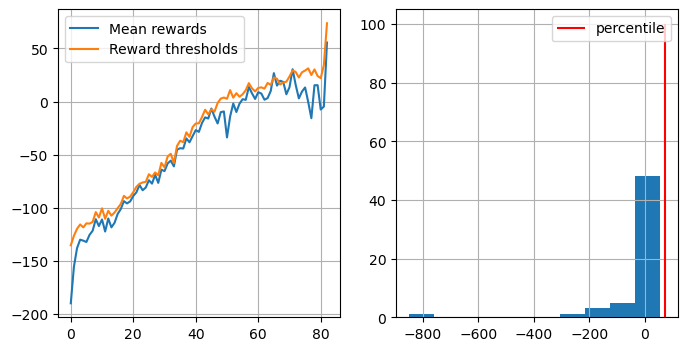

Done!
CPU times: total: 2min 39s
Wall time: 27min 29s


In [ ]:
%%time
np.random.seed(2023)
n_sessions = 100
percentile = 60
log = []
q_size = 3
queue = []

for _ in range(500):
    sessions = Parallel(n_jobs=-1, backend="loky")(delayed(generate_session)(env_moon, agent_lander, t_max=10**4) for _ in range(n_sessions))
    last_rewards_batch = np.array(list(zip(*sessions))[2])

    queue += sessions
    if len(queue) > (n_sessions * q_size):
        queue = queue[-(n_sessions * q_size):]

    states_batch, actions_batch, rewards_batch = map(np.array, zip(*queue))
    elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, percentile)

    agent_lander.partial_fit(elite_states, elite_actions)

    show_progress(last_rewards_batch, log, percentile, reward_range=[np.min(rewards_batch), 55])

    if np.mean(last_rewards_batch) > 50:
        print("Done!")
        break